# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

В распоряжении набор фотографий людей с указанием возраста.

# Исходные данные

1. Данные взяты с сайта ChaLearn Looking at People.
2. Данные находятся в папке /datasets/faces/. 
2. В распоряжении:
    - одна папка со всеми изображениями (/final_files)
    - CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image

In [3]:
images_path = '/datasets/faces/final_files/'

In [4]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [5]:
data.shape

(7591, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
display(data.head(5))
display(data.tail(5))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [8]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


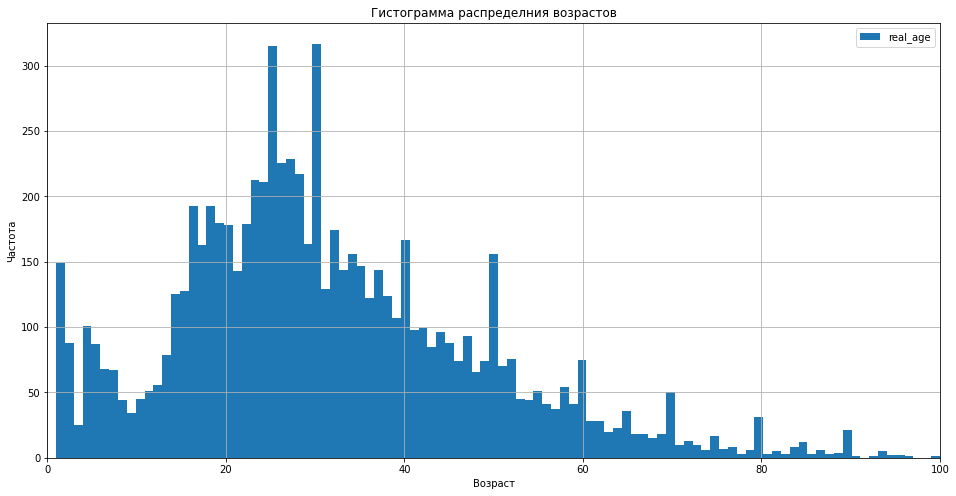

In [9]:
data.plot(
    kind='hist',
    bins=100,
    figsize=(16,8),
    ylabel="Возраст",
    title = "Гистограмма распределния возрастов",
    grid=True,
    xlim=(0,100))
plt.xlabel("Возраст")
plt.ylabel("Частота");

Промежуточный вывод:
 - на значение возраста 27-30 лет приходится максимум,
 - имеется максимум в значениях возраста до 10 лет,
 - наблюдаются определенная частотность значений возраста, кратные 10,
 - возможная причина - округление значений до ближайшего десятка, если возраст человека не известен.
    

Выведем на экрна 15 фотографий

In [10]:
datagen = ImageDataGenerator(rescale=1./255) 

In [11]:
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe = data,
    directory = images_path,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


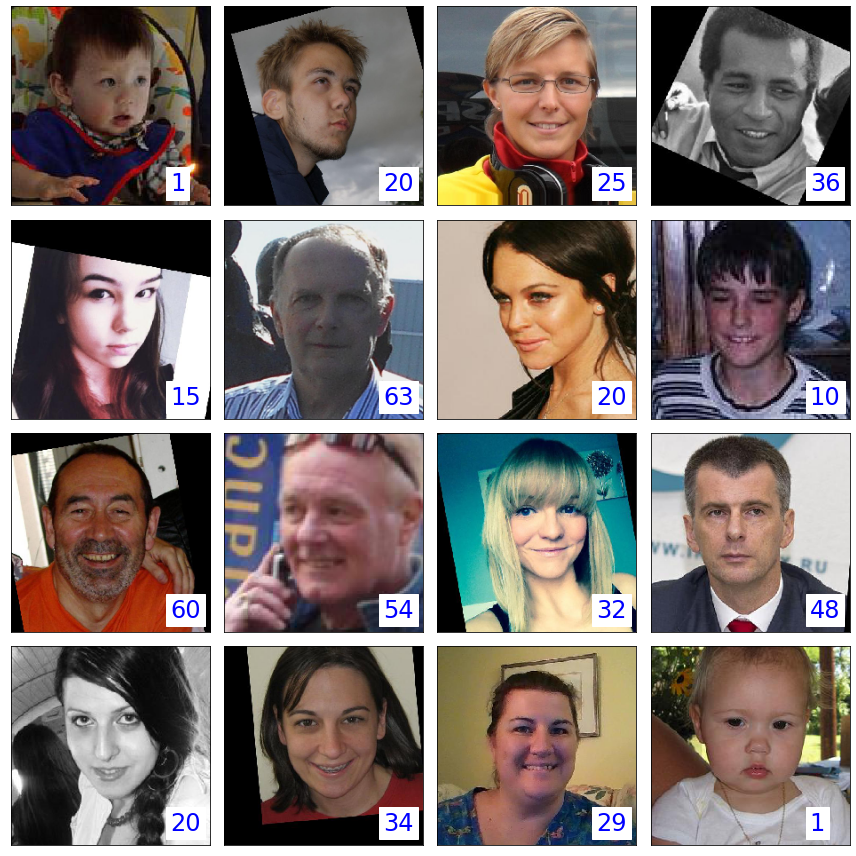

In [31]:
x, y = next(train_datagen_flow)
fig = plt.figure(figsize=(12,12))
for i in range(16):
    ax = fig.add_subplot(4,4, i+1)
    plt.imshow(x[i])
    plt.text(0.8, 0.075, y[i], fontsize = 24, transform=ax.transAxes, color='blue', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- После детекции, попавшие в вывод изображения - квадратные. На подавляющем большинстве изображены только лица людей, расположенные в центре.
- Иногда при выводе случайных фоторграфий В датасете присутствуют фотографии с дефектами на которых присутсвуют люди, но не видно лиц. Поскольку такое случалось несколько раз, можно предположить, что таких фоторафий не много.  Однако это приведет к тому, что полученная модель может ошибаться.

## Обучение модели

1. Для выполнялся на GPU на отдельном сервере были созданы следующие функции:
 - загрузка тренировочного датасета load_train(path),
 - загрузка тестового датасета load_test(path),
 - создание архитектуры сети create_model(input_shape)
 - обучение модели train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)

2. Данные разделены на тренировочный и тестовый в соотношении 75% : 25%.
3. В качестве моедли была выбрана 50-слойная модель ResNet50.

- Было протестировано несколько моеделй с различным количеством epoch в диапозоне 10-20  и показетелем learning_rate =  (0.0005, 0,0001);
- После расмотрения нескольких моделей c различными комибнациями данынх параметров, была выбрана моджель с параметрами learning_rate = 0,0001, epoch=10;

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd 
from tensorflow import keras

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape, 
        include_top=False)
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 99s - loss: 224.7702 - mean_absolute_error: 10.8403 - val_loss: 837.4187 - val_mean_absolute_error: 23.8792
Epoch 2/10
178/178 - 88s - loss: 89.6164 - mean_absolute_error: 7.1555 - val_loss: 827.2805 - val_mean_absolute_error: 23.6900
Epoch 3/10
178/178 - 88s - loss: 72.7123 - mean_absolute_error: 6.4395 - val_loss: 483.6001 - val_mean_absolute_error: 17.1478
Epoch 4/10
178/178 - 88s - loss: 58.3416 - mean_absolute_error: 5.8487 - val_loss: 143.1505 - val_mean_absolute_error: 9.0933
Epoch 5/10
178/178 - 88s - loss: 46.5043 - mean_absolute_error: 5.2096 - val_loss: 89.8929 - val_mean_absolute_error: 7.0689
Epoch 6/10
178/178 - 88s - loss: 39.7674 - mean_absolute_error: 4.8365 - val_loss: 88.9418 - val_mean_absolute_error: 7.0037
Epoch 7/10
178/178 - 91s - loss: 34.3649 - mean_absolute_error: 4.5138 - val_loss: 75.9590 - val_mean_absolute_error: 6.3279
Epoch 8/10
178/178 - 95s - loss: 32.0066 - mean_absolute_error: 4.3596 - val_loss: 92.9808 - val_mean_absolute_error: 7.3636
Epoch 9/10
178/178 - 92s - loss: 28.4203 - mean_absolute_error: 4.1314 - val_loss: 80.0346 - val_mean_absolute_error: 6.7227
Epoch 10/10
178/178 - 88s - loss: 25.0712 - mean_absolute_error: 3.8465 - val_loss: 74.6540 - val_mean_absolute_error: 6.2801

60/60 - 9s - loss: 74.6540 - mean_absolute_error: 6.2801
Test MAE: 6.2801
```

## Анализ обученной модели

- В качестве модели была выбрана 50-слойная модель ResNet50.
- Протестировано несколько варинатов модели с различными значениями параметров:
    - epoch = 10...20,
    - learning_rate = (0.0005, 0,0001);
- Была выбрана моджель с параметрами learning_rate = 0,0001, epoch=10;
- На тестовой выборке модель достигла значения MAE = 6.2 за 10 эпох;
- Ошибка модели предсказания возраста на тестовой выборке составляет 6-7 лет;
- Ошибка модели предсказания возраста на тренировочной выборке составляет 4 года;
- Полученое значение метрики MAE = 6.2 < 8, результат достигнут.